
# ⚙️ 03 - Model Training for BTC/USDT

**Objective:**  
In this notebook, we will **train a basic AI model** (a classifier) to predict whether the BTC/USDT price will move up or down in the near future. We'll use the features generated in `02_feature_engineering.ipynb`.

---

## 📌 Overview

1. **Load the enhanced dataset** (`BTCUSDT_1m_features.csv`).
2. **Define a target variable** (e.g., predict if the next close is higher than the current close).
3. **Split the data** into train and test sets.
4. **Train a baseline model** (e.g., Random Forest).
5. **Evaluate performance** with accuracy, confusion matrix, or other metrics.
6. **Discuss next steps** (hyperparameter tuning, model improvement, real-time integration).

---

## 💡 Why This Matters

- Feature engineering + a well-defined target variable + the right split → a good starting point for AI-based trading signals.
- You’ll see if your features actually help or if you need more advanced engineering.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1) Load the feature-enhanced dataset
df = pd.read_csv('../data/BTCUSDT_1m_features.csv')

print("Data loaded. Here are the first 5 rows:")
df.head()


Data loaded. Here are the first 5 rows:


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_volume,...,day_of_week,hour_of_day,ma_14,ema_14,bb_upper,bb_lower,rsi_14,close_lag1,close_lag2,returns_1m
0,2024-01-01 00:00:00,42283.58,42298.62,42261.02,42298.61,35.92724,2024-01-01 00:00:59.999,1.519032e+06,1327,23.18766,...,0,0,NaN,42298.610000,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01 00:01:00,42298.62,42320.00,42298.61,42320.00,21.16779,2024-01-01 00:01:59.999,8.955809e+05,1348,13.47483,...,0,0,NaN,42301.462000,NaN,NaN,NaN,42298.61,NaN,0.000506
2,2024-01-01 00:02:00,42319.99,42331.54,42319.99,42325.50,21.60391,2024-01-01 00:02:59.999,9.143711e+05,1019,11.21801,...,0,0,NaN,42304.667067,NaN,NaN,NaN,42320.00,42298.61,0.000130
3,2024-01-01 00:03:00,42325.50,42368.00,42325.49,42367.99,30.50730,2024-01-01 00:03:59.999,1.291997e+06,1241,24.04878,...,0,0,NaN,42313.110124,NaN,NaN,NaN,42325.50,42320.00,0.001004
4,2024-01-01 00:04:00,42368.00,42397.23,42367.99,42397.23,46.05107,2024-01-01 00:04:59.999,1.951945e+06,1415,34.12804,...,0,0,NaN,42324.326108,NaN,NaN,NaN,42367.99,42325.50,0.000690



## 🏷️ 1. Defining Our Target Variable

We want a simple target for now:
- **`target` = 1 if next close price is higher than current close**, else 0.

This is a classic **binary classification** approach: will the price go up or not?


In [2]:

# We'll shift the 'close' price by -1 to get the "next" bar's close
df['future_close'] = df['close'].shift(-1)

# Define target: 1 if future close > current close, else 0
df['target'] = (df['future_close'] > df['close']).astype(int)

# Drop rows with NaNs created by shifting (the very last row)
df.dropna(subset=['future_close'], inplace=True)

# Quick check
df[['close','future_close','target']].tail(10)


,close,future_close,target
14989,46271.09,46280.01,1
14990,46280.01,46265.99,0
14991,46265.99,46248.36,0
14992,46248.36,46256.47,1
14993,46256.47,46227.44,0
14994,46227.44,46223.16,0
14995,46223.16,46220.65,0
14996,46220.65,46234.01,1
14997,46234.01,46249.18,1
14998,46249.18,46220.12,0



## 🌐 2. Selecting Features for the Model

We'll pick columns that might help predict future price movements:
- **Technical indicators** (ma_14, ema_14, rsi_14, etc.)
- **Time-based** (day_of_week, hour_of_day)
- **Lagged data** (close_lag1, etc.)
- **Returns or volume**

We exclude anything that leaks future info (like `future_close` itself) and also avoid the raw `close` if we prefer only derived features, but we can experiment.


In [3]:

# Let's define a list of feature columns we want to use
feature_cols = [
    'ma_14','ema_14','bb_upper','bb_lower','rsi_14',
    'close_lag1','close_lag2','returns_1m',
    'day_of_week','hour_of_day','volume'
]

# Some columns might not exist if you removed or changed them
# We'll drop missing columns to avoid errors
available_cols = [c for c in feature_cols if c in df.columns]
X = df[available_cols].copy()

print("Feature columns being used:\n", available_cols)

# The target
y = df['target']

print(f"X shape: {X.shape}, y shape: {y.shape}")
X.head()


Feature columns being used:
 ['ma_14', 'ema_14', 'bb_upper', 'bb_lower', 'rsi_14', 'close_lag1', 'close_lag2', 'returns_1m', 'day_of_week', 'hour_of_day', 'volume']
X shape: (14999, 11), y shape: (14999,)


,ma_14,ema_14,bb_upper,bb_lower,rsi_14,close_lag1,close_lag2,returns_1m,day_of_week,hour_of_day,volume
0,NaN,42298.610000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,35.92724
1,NaN,42301.462000,NaN,NaN,NaN,42298.61,NaN,0.000506,0,0,21.16779
2,NaN,42304.667067,NaN,NaN,NaN,42320.00,42298.61,0.000130,0,0,21.60391
3,NaN,42313.110124,NaN,NaN,NaN,42325.50,42320.00,0.001004,0,0,30.50730
4,NaN,42324.326108,NaN,NaN,NaN,42367.99,42325.50,0.000690,0,0,46.05107



## 🧪 3. Splitting the Data into Train and Test

We’ll do a simple time-based split:
- Because it's time-series data, we must be careful about random splits that mix future data with past data.
- For a quick approach, we can do a normal `train_test_split` but **shuffle=False** to keep the time order.

Note: For advanced trading, you might do a more careful walk-forward split or time series split.


In [4]:

# Drop rows with any missing features
X = X.dropna()
y = y[X.index]  # Align target with dropped rows

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=False  # preserve time order
)

print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Train set size: 11984
Test set size: 2996


4 - Building neural network using tensorFlow

In [5]:
# 1. Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 2. Build the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # sigmoid because it's binary classification (buy/sell)
])

# 3. Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4. Summary of the model
model.summary()

/Users/elianhaddad/personal-projects/ia-developer/AI-Trading-Bot/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - accuracy: 0.5026 - loss: 937.6115
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - accuracy: 0.5007 - loss: 188.0192
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 0.4947 - loss: 196.8299
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0.5121 - loss: 170.9989
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.5023 - loss: 153.3513
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.5065 - loss: 110.0172
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.4992 - loss: 106.2821
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.4953 - loss: 131.4264
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.5012 - loss: 114.8718
Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.5069 - loss: 85.3822
Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.4908 - loss: 91.0617
Epoch 12/2

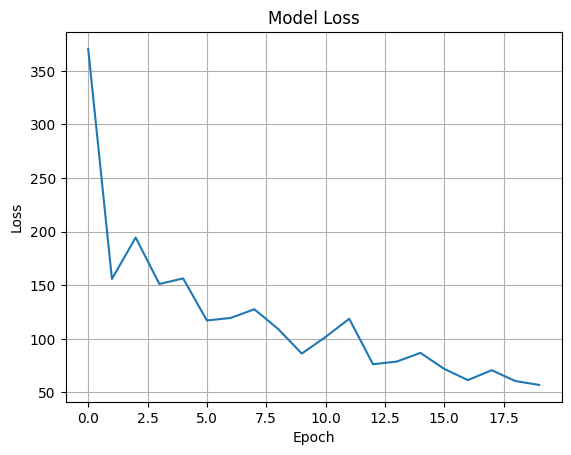

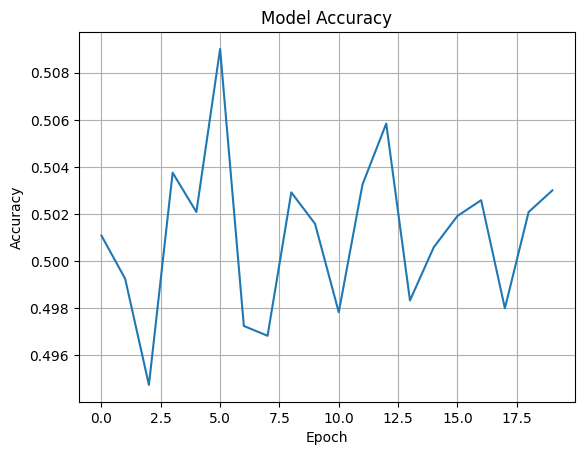

In [7]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

In [8]:
model.save('btc_trading_model.keras')

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.4891 - loss: 6.8847
Test Loss: 6.9848
Test Accuracy: 0.4866


In [10]:
from sklearn.model_selection import train_test_split

# Split the current X_train into a smaller train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.1,  # 10% for validation
    shuffle=False   # important: keep the time order!
)

print(f"New Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

New Train shape: (10785, 11)
Validation shape: (1199, 11)


In [11]:
# Retrain the model with validation data
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.5023 - loss: 66.0534 - val_accuracy: 0.5096 - val_loss: 40.1072
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.4917 - loss: 53.9734 - val_accuracy: 0.5096 - val_loss: 61.7180
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.4890 - loss: 53.8519 - val_accuracy: 0.4904 - val_loss: 70.3023
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.5036 - loss: 41.5108 - val_accuracy: 0.5088 - val_loss: 5.3461
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.4904 - loss: 42.0289 - val_accuracy: 0.4904 - val_loss: 112.4971
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 0.5040 - loss: 77.1390 - val_accuracy: 0.5096 - val_loss: 54.0144
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.5000 - loss: 41.2205 - val_accuracy: 0.5096 - val_loss: 67.5693
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.5014 - l

In [12]:
from sklearn.preprocessing import StandardScaler

# 1. Create a scaler
scaler = StandardScaler()

# 2. Fit the scaler ONLY on training data
scaler.fit(X_train)

# 3. Transform training, validation, and test data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete! Shapes:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_val_scaled: {X_val_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

Scaling complete! Shapes:
X_train_scaled: (10785, 11)
X_val_scaled: (1199, 11)
X_test_scaled: (2996, 11)


In [13]:
# 1. Build a new model (same architecture)
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# 2. Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 3. Train the model on scaled data
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_scaled, y_val)
)

Epoch 1/20


/Users/elianhaddad/personal-projects/ia-developer/AI-Trading-Bot/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.5019 - loss: 0.6992 - val_accuracy: 0.4837 - val_loss: 0.7013
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.5252 - loss: 0.6917 - val_accuracy: 0.5138 - val_loss: 0.6946
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.5288 - loss: 0.6912 - val_accuracy: 0.5196 - val_loss: 0.6945
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - accuracy: 0.5285 - loss: 0.6906 - val_accuracy: 0.4862 - val_loss: 0.7034
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.5247 - loss: 0.6899 - val_accuracy: 0.5071 - val_loss: 0.6996
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.5356 - loss: 0.6898 - val_accuracy: 0.5104 - val_loss: 0.7005
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.5380 - loss: 0.6891 - val_accuracy: 0.4996 - val_loss: 0.7139
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.5328 - loss: 0.6898 - val_accurac